In [19]:
import numpy as np
import pandas as pd
import torch
import random
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset
from sklearn.preprocessing import MinMaxScaler
import sklearn
from sklearn.preprocessing import OneHotEncoder
from prettytable import PrettyTable
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import sys
#from umap.parametric_umap import ParametricUMAP
device = torch.device('cuda:0')
sys.path.append('../../')
from src.models.frequency.sketch_algorithms import SketchQueryalgorithms
from src.scripts.frequency_membership.train_sqn import define_networks
from src.datasets.zipf import get_zipf_probs, get_dataset_samples, ZipfOnlineDatasetLoader
from src.datasets.read_data import load_data

This notebook evaluates different models using zipf dataset. The aim is to finc the best combination of hyperparameters.

In [15]:
hparams_sk100 = { 
    'task':'frequency_estimation',
    'train_SN_QN':1,
    'models_sqnet': ['../../results/networks/networks_sketch_100/networks_frequency_sqnet/',
                     '../../results/networks/networks_sketch_100/networks_frequency_sqnet/',
                     '../../results/networks/networks_sketch_100/networks_frequency_sqnet/',
                     '../../results/networks/networks_sketch_100/networks_frequency_sqnet/',
                     '../../results/networks/networks_sketch_100/networks_frequency_sqnet/',
                     '../../results/networks/networks_sketch_100/networks_frequency_sqnet/',
                     '../../results/networks/networks_sketch_100/networks_frequency_sqnet/'
                     ],
    'models_rfqnet': ['../../results/networks/networks_sketch_100/networks_frequency_rf/',
                      '../../results/networks/networks_sketch_100/networks_frequency_rf/',
                      '../../results/networks/networks_sketch_100/networks_frequency_rf/',
                      '../../results/networks/networks_sketch_100/networks_frequency_rf/',
                      '../../results/networks/networks_sketch_100/networks_frequency_rf/',
                      '../../results/networks/networks_sketch_100/networks_frequency_rf/',
                      '../../results/networks/networks_sketch_100/networks_frequency_rf/',
                      '../../results/networks/networks_sketch_100/networks_frequency_rf/',
                      ],
    'activations':['relu','lrelu','gelu','tanh','sigmoid','cos','sin','rff'],
    'poolings':['Mean','Min','Max','Log-sum-exp','p-norm','-1*log-sum-exp(-x)','-1*p-norm(-x)'],
    'residual':[0,0,0,0,0,0,0],
    'n_dims':1000,
    'batch_size':500,
    'num_samples':100,
    'sketch_size':100,
    'hidden_dim':2000,
    'num_hidden':3, # In residual
    'variances':[0.6,0.6,0.6,0.2,0.6,0.6,0.005,0.005],
    'order':[2,2,2,2,6,2,8], # In p-norm and -1*p-norm(-x)
}


In [3]:
hparams_sk100 = { 
    'task':'frequency_estimation',
    'train_SN_QN':0,
    'models_sqnet': ['../../results/networks/networks_sketch_100/networks_frequency_sqnet_residual/',
                     '../../results/networks/networks_sketch_100/networks_frequency_sqnet_residual/',
                     '../../results/networks/networks_sketch_100/networks_frequency_sqnet_residual/',
                     '../../results/networks/networks_sketch_100/networks_frequency_sqnet_residual/',
                     '../../results/networks/networks_sketch_100/networks_frequency_sqnet_residual/',
                     ],
    'models_rfqnet': ['../../results/networks/networks_sketch_100/networks_frequency_rf/',
                      '../../results/networks/networks_sketch_100/networks_frequency_rf/',
                      '../../results/networks/networks_sketch_100/networks_frequency_rf/',
                      '../../results/networks/networks_sketch_100/networks_frequency_rf/',
                      '../../results/networks/networks_sketch_100/networks_frequency_rf/',
                      ],
    'activations':['tanh','tanh','tanh','tanh','tanh'],
    'poolings':['Mean','Mean','Mean','Mean','Mean'],
    'residual':[0,0,0,0,0],
    'n_dims':1000,
    'batch_size':500,
    'num_samples':100,
    'sketch_size':100,
    'hidden_dim':2000,
    'num_hidden':1, # In residual
    'variances':[0.005,0.2,0.6,0.8,1.0],
    'order':[2,4,6,8,10], # In p-norm and -1*p-norm(-x)
}


In [45]:
hparams = { 
    'task':'frequency_estimation',
    'train_SN_QN':0,
    'models_sqnet': ['../../results/networks/networks_sketch_10/networks_frequency_sqnet/',
                     '../../results/networks/networks_sketch_10/networks_frequency_sqnet/',
                     '../../results/networks/networks_sketch_10/networks_frequency_sqnet/',
                     '../../results/networks/networks_sketch_10/networks_frequency_sqnet/',
                     '../../results/networks/networks_sketch_10/networks_frequency_sqnet/',
                     '../../results/networks/networks_sketch_10/networks_frequency_sqnet/',
                     '../../results/networks/networks_sketch_10/networks_frequency_sqnet/'
                     ],
    'models_rfqnet': ['../../results/networks/networks_sketch_10/networks_frequency_rf/',
                      '../../results/networks/networks_sketch_10/networks_frequency_rf/',
                      '../../results/networks/networks_sketch_10/networks_frequency_rf/',
                      '../../results/networks/networks_sketch_10/networks_frequency_rf/',
                      '../../results/networks/networks_sketch_10/networks_frequency_rf/',
                      '../../results/networks/networks_sketch_10/networks_frequency_rf/',
                      '../../results/networks/networks_sketch_10/networks_frequency_rf/',
                      '../../results/networks/networks_sketch_10/networks_frequency_rf/',
                      ],
    'activations':['relu','lrelu','gelu','tanh','sigmoid','cos','sin','rff'],
    'poolings':['Mean','Min','Max','Log-sum-exp','p-norm','-1*log-sum-exp(-x)','-1*p-norm(-x)'],
    'residual':[0,0,0,0,0,0,0],
    'n_dims':1000,
    'batch_size':500,
    'num_samples':100,
    'sketch_size':10,
    'hidden_dim':2000,
    'num_hidden':3, # In residual
    'variances':[0.6,0.6,0.6,0.6,0.6,0.6,0.6,1.0],
    'order':[2,2,2,2,8,2,10], # In p-norm and -1*p-norm(-x)
}


In [32]:
hparams = { 
    'task':'frequency_estimation',
    'train_SN_QN':1,
    'models_sqnet': ['../../results/networks/networks_sketch_10/networks_frequency_sqnet/',
                     '../../results/networks/networks_sketch_10/networks_frequency_sqnet/',
                     '../../results/networks/networks_sketch_10/networks_frequency_sqnet/',
                     '../../results/networks/networks_sketch_10/networks_frequency_sqnet/',
                     '../../results/networks/networks_sketch_10/networks_frequency_sqnet/',
                     ],
    'models_rfqnet': ['../../results/networks/networks_sketch_10/networks_frequency_rf/',
                      '../../results/networks/networks_sketch_10/networks_frequency_rf/',
                      '../../results/networks/networks_sketch_10/networks_frequency_rf/',
                      '../../results/networks/networks_sketch_10/networks_frequency_rf/',
                      '../../results/networks/networks_sketch_10/networks_frequency_rf/',
                      ],
    'activations':['tanh','tanh','tanh','tanh','tanh'],
    'poolings':['-1*p-norm(-x)','-1*p-norm(-x)','-1*p-norm(-x)','-1*p-norm(-x)','-1*p-norm(-x)'],
    'residual':[0,0,0,0,0],
    'n_dims':1000,
    'batch_size':500,
    'num_samples':100,
    'sketch_size':10,
    'hidden_dim':2000,
    'num_hidden':1, # In residual
    'variances':[0.005,0.2,0.6,0.8,1.0],
    'order':[2,4,6,8,10], # In p-norm and -1*p-norm(-x)
}

In [21]:
def read_model(path_sqnet,path_rfqnet,hparams):
    # define networks
    SN,QN = define_networks(hparams)
    # Load models
    SN.load_state_dict(torch.load(path_sqnet))
    QN.load_state_dict(torch.load(path_rfqnet))
    SN.eval()
    QN.eval()
    return SN,QN 

    

In [22]:
def compute_errors(x,y,SN,QN,hparams,metric):
    # Evaluation of the models
    with torch.no_grad():
        sketch = SN(x, mean_dim=1,type_lastlayer=hparams['type_lastlayer_sq'],order_norm=hparams['order_norm_sq'])
        y_hat = torch.sigmoid(QN(sketch)).squeeze()
        error = torch.mean(metric(y_hat.cpu()-y.cpu()))
    return error.item()
        

In [23]:
def compute_plot_zoomalpha(err,space,model_names,residual):
    fig = plt.figure(figsize=(13, 4)) 
    ax1 = plt.subplot(1,2,1)
    for i in range(len(err)):
        if residual[i]==1:
            n = model_names[i] #+ ' residual'
        else:
            n = model_names[i]
        ax1.plot(space,err[i],label='{}'.format(n))
    plt.xlabel("Alpha")
    plt.ylabel("MSE")    
    half = int(len(space)/2) # 2
    ax2 = plt.subplot(1,2,2) # rows,columns, fig
    for i in range(len(err)):
        if residual[i]==1:
            n = model_names[i] #+ ' residual'
        else:
            n = model_names[i]
        error = err[i]
        ax2.plot(space[half:],error[half:],label='{}'.format(n))
    ax2.yaxis.tick_right()
    plt.xlabel("Alpha")
    plt.xlim([space[half], space[len(space)-1]])
    mark_inset(ax1, ax2, loc1=2, loc2=3, fc="none", ec="0.5")
    plt.legend(bbox_to_anchor=(-0.6, -0.60, 1., .102),
       ncol=4, mode="expand", borderaxespad=-7.0,prop={'family':'Serif','size':10})
    #plt.savefig('../../results/plots_comparation_zipf/frequency_rfqnet_zoomMSE', bbox_inches='tight')
    plt.show()
    plt.close()

In [49]:
def compute_plot_zoomMSE(err,space,model_names,residual):
    fig = plt.figure(figsize=(13, 4)) 
    ax1 = plt.subplot(1,2,1)
    for i in range(len(err)):
        if residual[i]==1:
            n = model_names[i] + ' residual'
        else:
            n = model_names[i]
        ax1.plot(space,err[i],label='{}'.format(n))
    plt.xlabel("Alpha")
    plt.ylabel("MSE")    

    ax2 = plt.subplot(1,2,2) # rows,columns, fig
    for i in range(len(err)):
        if residual[i]==1:
            n = model_names[i] + ' residual'
        else:
            n = model_names[i]
        ax2.plot(space,err[i],label='{}'.format(n))
    ax2.yaxis.tick_right()
    plt.xlabel("Alpha")
    #plt.xlim([space[half], space[len(space)-1]])
    if hparams['task'] == 'frequency_estimation':  
        plt.ylim([0, 0.01])
        plt.xlim([0.1, 2.0])
    else:
        plt.ylim([0, 0.05])
        plt.xlim([0.1, 2.0]) #1.1
    mark_inset(ax1, ax2, loc1=2, loc2=3, fc="none", ec="0.5")
    plt.legend(bbox_to_anchor=(-0.6, -0.60, 1., .102),
       ncol=4, mode="expand", borderaxespad=-7.0,prop={'family':'Serif','size':10})
    #plt.savefig('../../results/plots_comparation_zipf/frequency_rfqnet_poolings_zoomMSE_sk10', bbox_inches='tight')
    plt.show()
    plt.close()

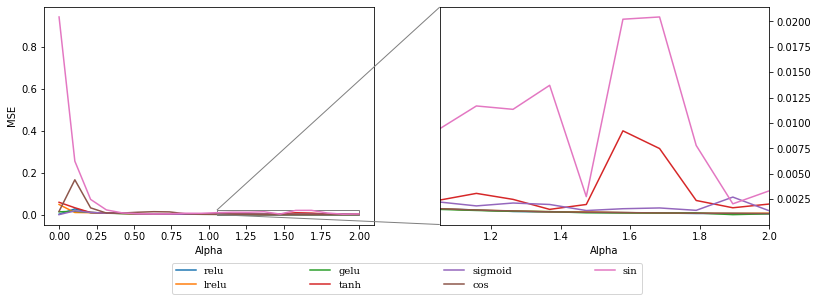

In [46]:
space = torch.linspace(0.0, 2.0, 20) # 50 1-3
Beta = 1
err = np.zeros([len(hparams['models_sqnet']),len(space)])
space_i = -1
metric = torch.square
for alpha in space:
    space_i += 1
    # For each alpha and Beta define the dataset
    # membership estimation 500x10x1000 (batch x num_samples x num_dim)
    # frequency estimation 500x100x1000
    # Define class dataset
    zipfdatasetloader = ZipfOnlineDatasetLoader(hparams['batch_size'], hparams['n_dims'], hparams['num_samples'], alpha_min=alpha, alpha_max=alpha,beta_min=Beta, beta_max=Beta,device=device)
    for j, (x,y) in enumerate(zipfdatasetloader):
        if j == 0:
            if hparams['task'] == 'membership_estimation':
                y[y == 0] = 0
                y[y > 0] = 1     
            for model in range(len(hparams['models_sqnet'])):
                # SQNet
                if hparams['train_SN_QN']==1:
                    hparams['type_lastlayer_sq'] = hparams['poolings'][model]
                    hparams['residual_sketch_net'] = hparams['residual'][model]
                    hparams['order_norm_sq'] = hparams['order'][model]
                    name = hparams['type_lastlayer_sq']
                    name_m = 'models_sqnet'
                    if hparams['order_norm_sq'] > 2 and ( hparams['type_lastlayer_sq'] == 'p-norm' or hparams['type_lastlayer_sq'] == '-1*p-norm(-x)'):
                        name += str(hparams['order_norm_sq'])
                # RFQnet
                else:
                    hparams['activation'] = hparams['activations'][model]
                    hparams['type_lastlayer_sq'] = 'Mean'
                    hparams['order_norm_sq'] = 2
                    name = hparams['activation']
                    hparams['var'] = hparams['variances'][model]
                    name_m = 'models_rfqnet'
                    if hparams['var'] < 1:
                        name += str(hparams['var'])

                path_sqnet = hparams[name_m][model] + 'snet_sq_'+ name +'.pth'
                path_rfqnet = hparams[name_m][model] + 'qnet_sq_'+ name +'.pth'
                # Read model
                sqnet,rfqnet = read_model(path_sqnet,path_rfqnet,hparams)
                # Compute errors
                error = compute_errors(x,y,sqnet,rfqnet,hparams,metric)
                err[model,space_i] = error

if hparams['train_SN_QN']==1:
    model_names = hparams['poolings']
    residual = hparams['residual']
else:
    model_names = hparams['activations']
    residual = ['','','','','','','','']
compute_plot_zoomalpha(err,space,model_names,residual)  
compute_plot_zoomMSE(err,space,model_names,residual)